## Capstone - Speech Emotion Recognition 

### Libraries imports

In [1]:
#pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#pip install --upgrade tensorflow

In [3]:
# Import libraries 
import librosa
import librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import IPython.display as ipd  # To play sound in the notebook
import os, glob, pickle
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Retrieve RAVDESS dataset from File System

In [4]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "../datasets/RAVDESS/"
#RAV = "../datasets/RAVDESS/audio_speech_actors_01-24/"
#SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
#CREMA = "../datasets/AudioWAV/"

# Run one example 
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

### Data statistics by motion and gender

In [5]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
#loop to get all actor's sound files path
#print("actor folder:"+i)
for i in dir_list:
    fname = os.listdir(RAV + i)
    #to get all actor's relative file path
    #print("relative path for "+i+": "+RAV+i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_fear        96
female_happy       96
male_angry         96
female_disgust     96
female_calm        96
female_surprise    96
male_fear          96
male_happy         96
female_sad         96
male_surprise      96
male_disgust       96
male_calm          96
female_angry       96
male_sad           96
female_neutral     48
male_neutral       48
Name: labels, dtype: int64

### Waveform view for Different Emotions

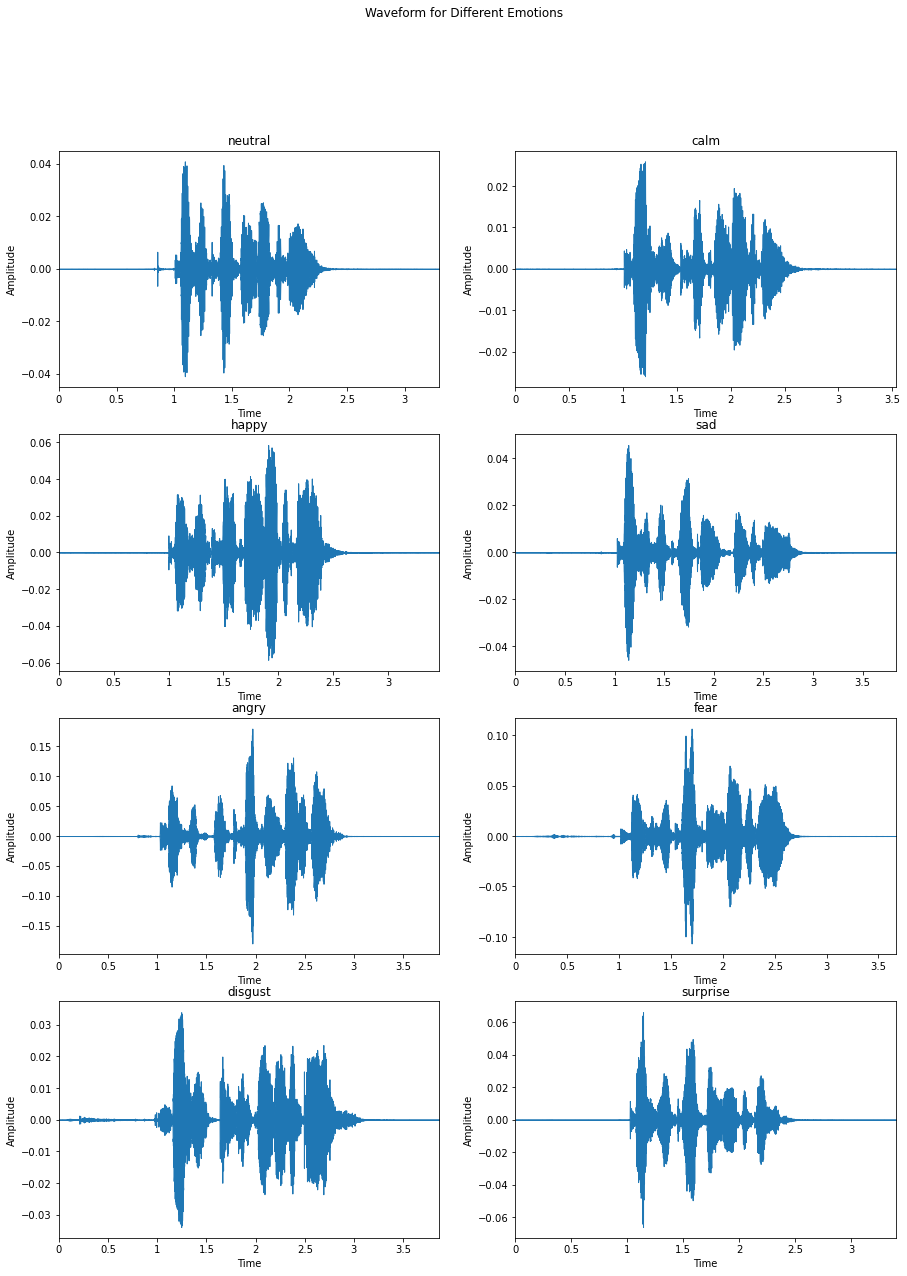

In [6]:
# Pick all the emotions
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
data = []
sampling_rate = []
file_name=[]
ax = {}

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))

fig.suptitle('Waveform for Different Emotions')
k=0
for i in range (4):
    for j in range (2):
        #print(RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01.wav')
        fr=RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01-01.wav'
        da, sr = librosa.load(fr)
        data.append(da)
        sampling_rate.append(sr)
        file_name.append(fr)
        ax[i][j].set_title(all_emotions[k])
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
        k=k+1;

In [7]:
# 0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'
ipd.Audio(file_name[7])

### Speech Emotion Compared by Gender

../datasets/RAVDESS/Actor_01/03-01-02-01-01-01.wav
../datasets/RAVDESS/Actor_01/03-01-02-01-01-02.wav
../datasets/RAVDESS/Actor_01/03-01-04-01-01-01.wav
../datasets/RAVDESS/Actor_01/03-01-04-01-01-02.wav
../datasets/RAVDESS/Actor_01/03-01-06-01-01-01.wav
../datasets/RAVDESS/Actor_01/03-01-06-01-01-02.wav
../datasets/RAVDESS/Actor_01/03-01-08-01-01-01.wav
../datasets/RAVDESS/Actor_01/03-01-08-01-01-02.wav


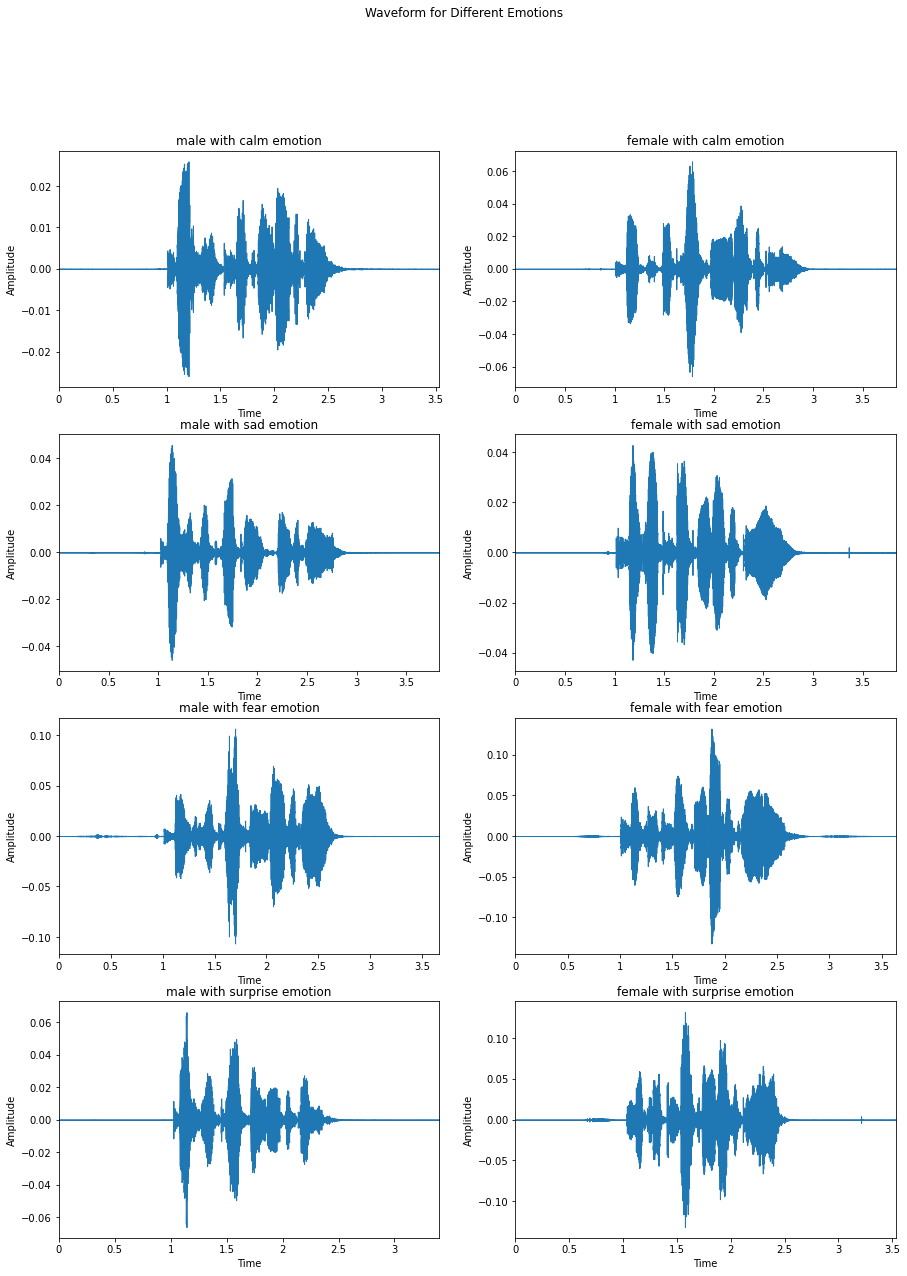

In [8]:
# Pick selected the emotions
selected_emotions=['calm', 'sad',  'fear', 'surprise']

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))
file_name_by_gender=[]
fig.suptitle('Waveform for Different Emotions')
k=2
m=0
for i in range (4):
    for j in range (2):
        
        if(j==0):
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01.wav')
            fr=RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01-01.wav'
            gender="male"
        else :
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-02.wav')
            fr=RAV + 'Actor_02/03-01-0'+str(k)+'-01-01-01-02.wav' 
            gender="female"
        da, sr = librosa.load(fr)
        file_name_by_gender.append(fr)
        ax[i][j].set_title(gender+" with "+ selected_emotions[m]+" emotion")
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
    k=k+2
    m=m+1

In [9]:
# 0:'male with calm', 1:'female with calm', 2:'male with sad', 3:'female with sad', 4:'male with fear', 5:'female with fear', 
# 6:'male with surprise'7:'female with surprise'
ipd.Audio(file_name_by_gender[7])

### Spectrogram View for Different Emotions

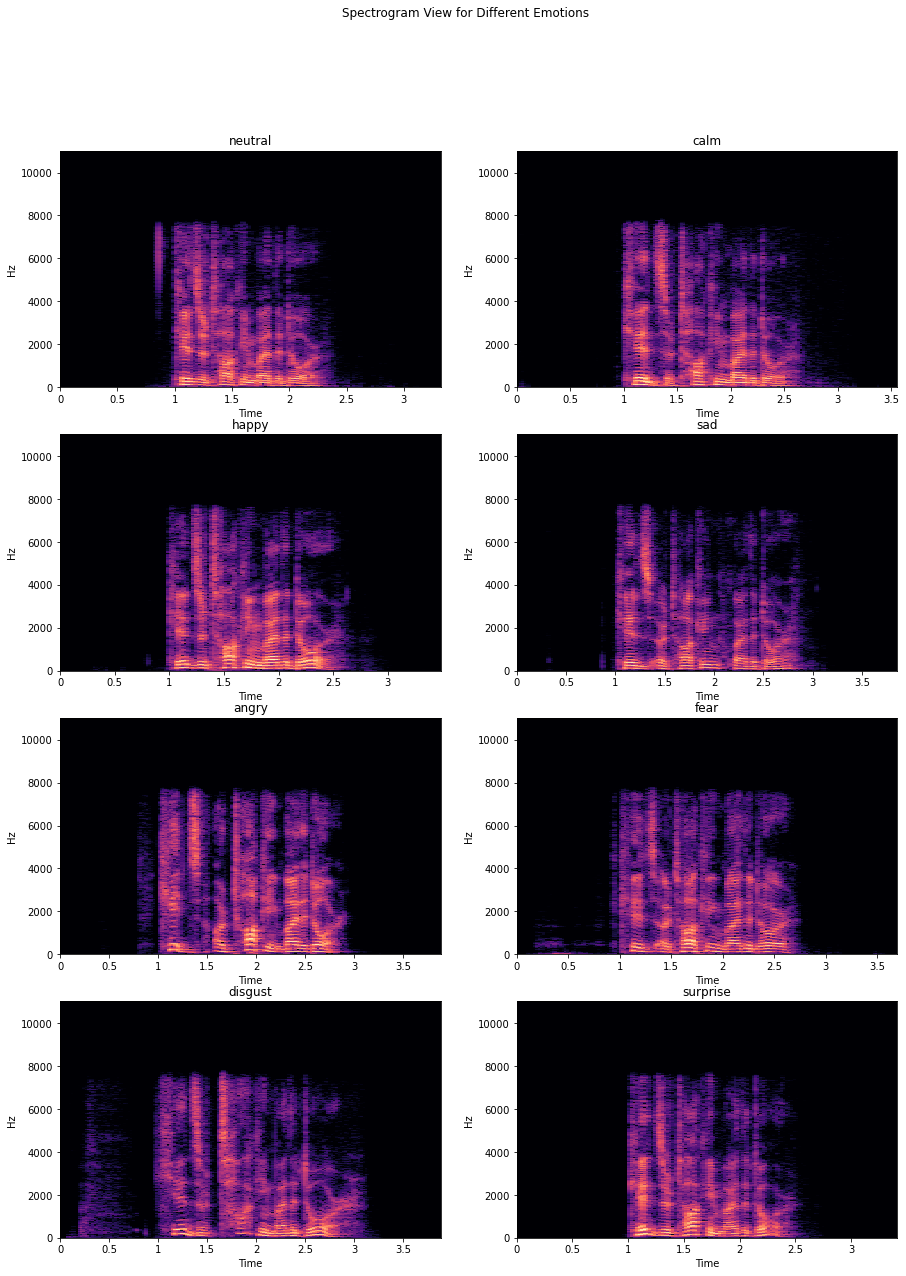

In [10]:
ax1 = {}
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Spectrogram View for Different Emotions')
k=0
for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',ax=ax1[i][j])
        k=k+1;

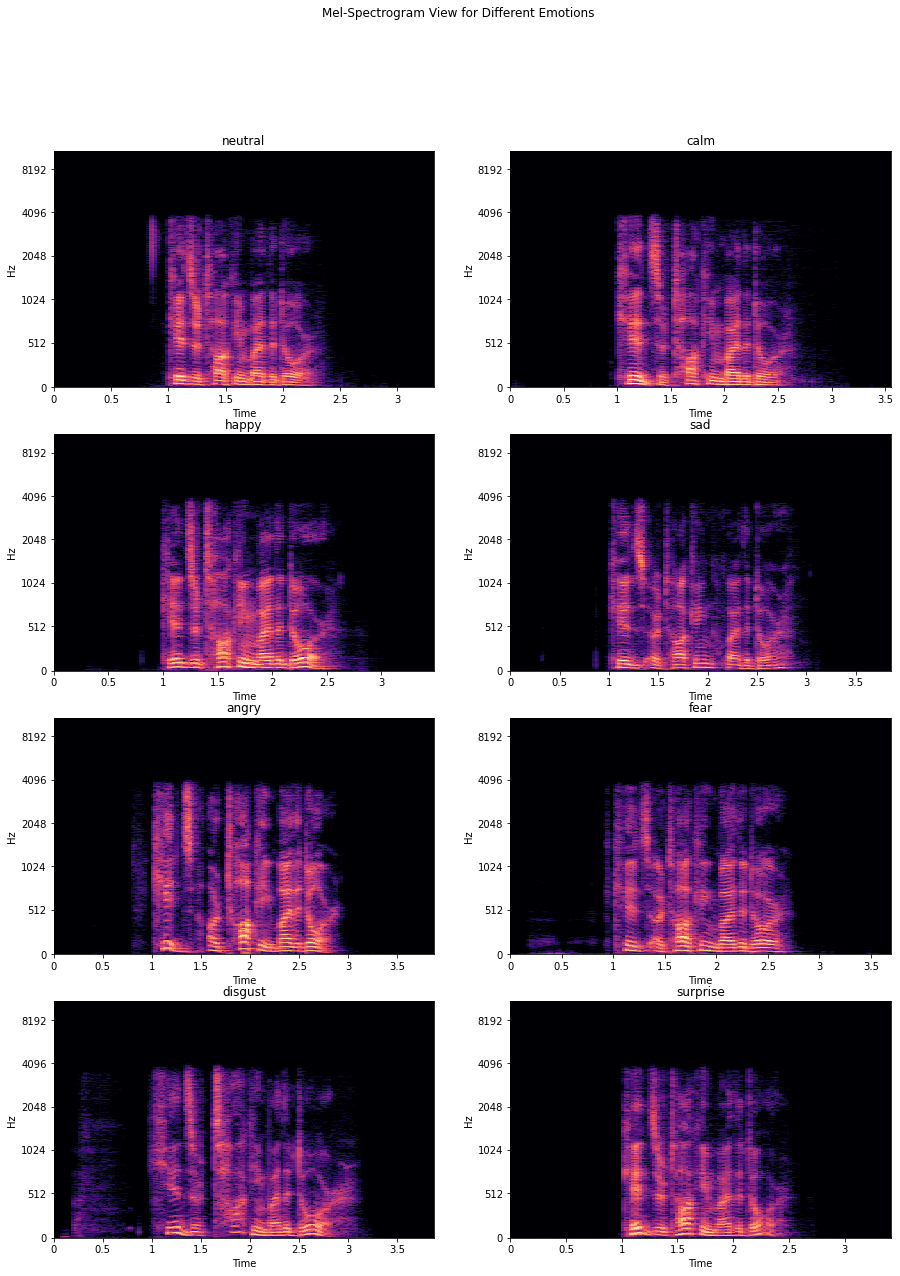

In [11]:
ax1 = {}
all_emotions=['neutral','calm','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Mel-Spectrogram View for Different Emotions')
k=0

for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',ax=ax1[i][j])
        k=k+1;